<a href="https://colab.research.google.com/github/badadumTss/convDAE/blob/main/ConvDAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, background
As backend for this project we'll use [tensorflow.keras](https://keras.io/), Google's deep learning API.

![Tensorflow logo](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png)

TensorFlow is an end-to-end open source platform for machine learning, it is made of an ecosystem of tools, libraries and collective resources that allow developers to easily develop and mantain machine learning powered applications.  TensorFlow was originally developed by researchers and engineers working on the Google Brain team within Google's Machine Intelligence Research organization to conduct machine learning and deep neural networks research. The system is general enough to be applicable in a wide variety of other domains, as well. It is one of the biggest and most known libraries to do machine learning and plenty of tech companies (such as google, AirBnB, Twitter, Intel, ...) use it everyday. It contains a full toolkit for building an deploying ML applications, including deep learning primitives such as network layer types, activation and loss functions, various optimizers and a lot more. It includes out of the box various tools to also work with computer vision, text, natural language and audio applications.

![Numpy logo](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/NumPy_logo_2020.svg/512px-NumPy_logo_2020.svg.png)

Another useful library is [numpy](https://numpy.org) wich is the de-facto standard in mathematical analysis with python. It offers a wide range of mathematica functions to do all sorts of stuff and is Highly performant in matrix multiplication compared to other solutions (Matlab included).

![Matplotlib logo](https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Created_with_Matplotlib-logo.svg/128px-Created_with_Matplotlib-logo.svg.png)

Matplotlib finally is used to plot data (e.g. loss function against epochs in training) and generally diaply images.

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import cifar10, fashion_mnist
from tensorflow.keras.regularizers import L1
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2

# The LinearAutoencoder

The first this we can define is a linear autoencoder for single-channeled (black and white) images. to our model we can give as input the image size (in height and width), some filters, that will rapresent the internal layers of the network (for example a filter like (32,64) indicates that the modell will be built with a first layer of 64 nodes and a second one of 32 for encodeing, and vice-versa 32 and then 64 nodes for decoding) and finally the latent dimension of the encoder, that rapresents the encoded space of it

![Rapresentation](https://miro.medium.com/max/1400/0*q3rUaf3JGbLlOopP.png)

This is a linear model since each layer is composed of a linearly activated layer (`Dense`), a `BatchNormalization` and a `LeakyReLU`. So each layer is linearly activated.

The build function returns separately the encoder, the decoder and the autoencoder (the combination of the two) in case we also want to visualize latent code or decode random noise to see the features that the model better learnt during the training process.

In [ ]:
class LinearAutoencoder:
  @staticmethod
  def build(width, height, filters=(32,64), latentDim=16):
    inputShape = height * width
    channelDim = -1
    inputs = Input(shape=(inputShape,))
    x = inputs
    for f in reversed(filters):
      x = Dense(units=f)(x)
      x = BatchNormalization()(x)
      x = LeakyReLU()(x)
    # encoded space
    latent = Dense(units=latentDim,
              activation='linear',
              activity_regularizer=L1(0.0001))(x)
    # encoder
    encoder = Model(inputs, latent, name='encoder')
    # decoder start
    latentInputs = Input(shape=(latentDim,))
    y = latentInputs
    for f in filters:
      y = Dense(units=f)(y)
      y = BatchNormalization()(y)
      y = LeakyReLU()(y)
    
    outputs = Dense(units=inputShape, activation='sigmoid')(y)
    decoder = Model(latentInputs, outputs, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
    return (encoder, decoder, autoencoder)

## MNIST fashion dataset

The dataset we'll use for this project is the MNIST-fashion dataset (from [zalando research](https://github.com/zalandoresearch/fashion-mnist)). It is composed of a training set of 60.000 examples and a test set of 10.000 examples of 28x28 greyscale images associated with 10 classes (explicit names in `class_names`).

In [ ]:
print("[INFO] loading MNIST fashion dataset...")
((fashion_train, train_labels), (fashion_test, _)) = fashion_mnist.load_data()

fashion_train = fashion_train.astype("float32") / 255.0
fashion_test = fashion_test.astype("float32") / 255.0

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

[INFO] loading MNIST fashion dataset...


We download the dataset directly from tensorflow, and directly normalize it over its norm (`255`) this way the images are now rapresented as vectors of length 1 (components between 0 and 1). We can then plot the images with `matplotlib` and see what the dataset contains.

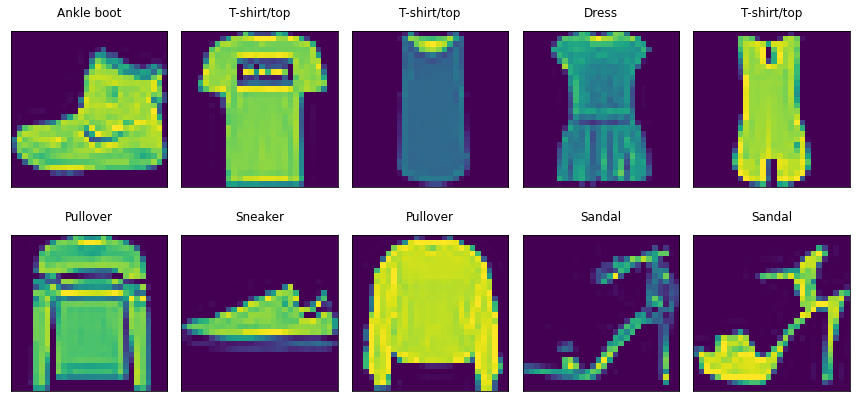

In [ ]:
# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(fashion_train[n])
        axs[i,j].set(title=class_names[train_labels[n]])
        n=n+1

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

We can now add noise to our images. The function `add_noise_and_clip_data` adds random values to each image and then clips it again in the range [0,1], in order to keep the vector normalized.

In [ ]:
def add_noise_and_clip_data(data, noise_factor=0.5):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + (noise * noise_factor)
   data = np.clip(data, 0., 1.)
   return data

In [ ]:
fashion_train_noisy = add_noise_and_clip_data(fashion_train)
fashion_test_noisy = add_noise_and_clip_data(fashion_test)

We can now see how our noised images look like and compare them to the ones above.

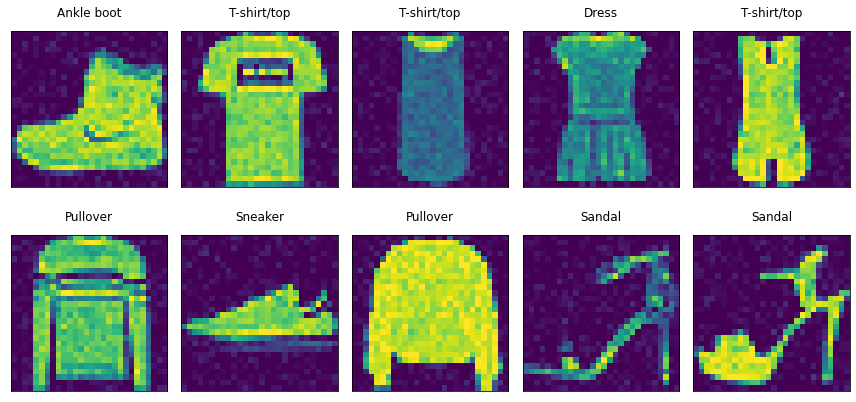

In [ ]:
# Display images of the first 10 digits in the noisy training data
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(fashion_train_noisy[n])
        axs[i,j].set(title=class_names[train_labels[n]])
        n=n+1

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

Our model takes as input vectors however, this is why we need to reshape the sets of clean and noised images to work with our model.

In [ ]:
fashion_train = fashion_train.reshape(60000, 784)
fashion_test = fashion_test.reshape(10000, 784)
fashion_train_noisy = fashion_train_noisy.reshape(60000, 784)
fashion_test_noisy = fashion_test_noisy.reshape(10000, 784)

## Training
Now that our dataset is ready we can fit the model over it. 

First we choose our optimizer (Adam seems to be a common choice over various implementations, since works particularly well with normalized images). 

Secondly we build the autoencoder tuning in the filters and the latent dimension.

And finally with `autoencoder.fit` start to train the model against our data.

In [ ]:
LR = 1e-3
EPOCHS = 30
BATCH = 32

FILTERS = [784]
LD = 784

optimizer = Adam(learning_rate = LR)

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = LinearAutoencoder.build(28, 28, filters=FILTERS, latentDim=LD)

autoencoder.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])

# train the convolutional autoencoder
H = autoencoder.fit(
 fashion_train_noisy, fashion_train,
 validation_data=(fashion_test_noisy, fashion_test),
 epochs=EPOCHS,
 batch_size=BATCH
)

[INFO] building autoencoder...
Epoch 1/30
1875/1875 [==============================] - 10s 4ms/step - loss: 0.0218 - accuracy: 0.0356 - val_loss: 0.0160 - val_accuracy: 0.0428
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0130 - accuracy: 0.0568 - val_loss: 0.0132 - val_accuracy: 0.0631
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0102 - accuracy: 0.0685 - val_loss: 0.0111 - val_accuracy: 0.0692
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0084 - accuracy: 0.0807 - val_loss: 0.0097 - val_accuracy: 0.0817
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - accuracy: 0.0919 - val_loss: 0.0075 - val_accuracy: 0.0719
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0058 - accuracy: 0.1000 - val_loss: 0.0066 - val_accuracy: 0.0879
Epoch 7/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0053 - accuracy: 0.1062 - 

Now that we have trained the model, the history of loss and value loss over each epoch is ready, and we can see how it performed by plotting the values the loss function assumend during the training and the test steps at each iteration. 

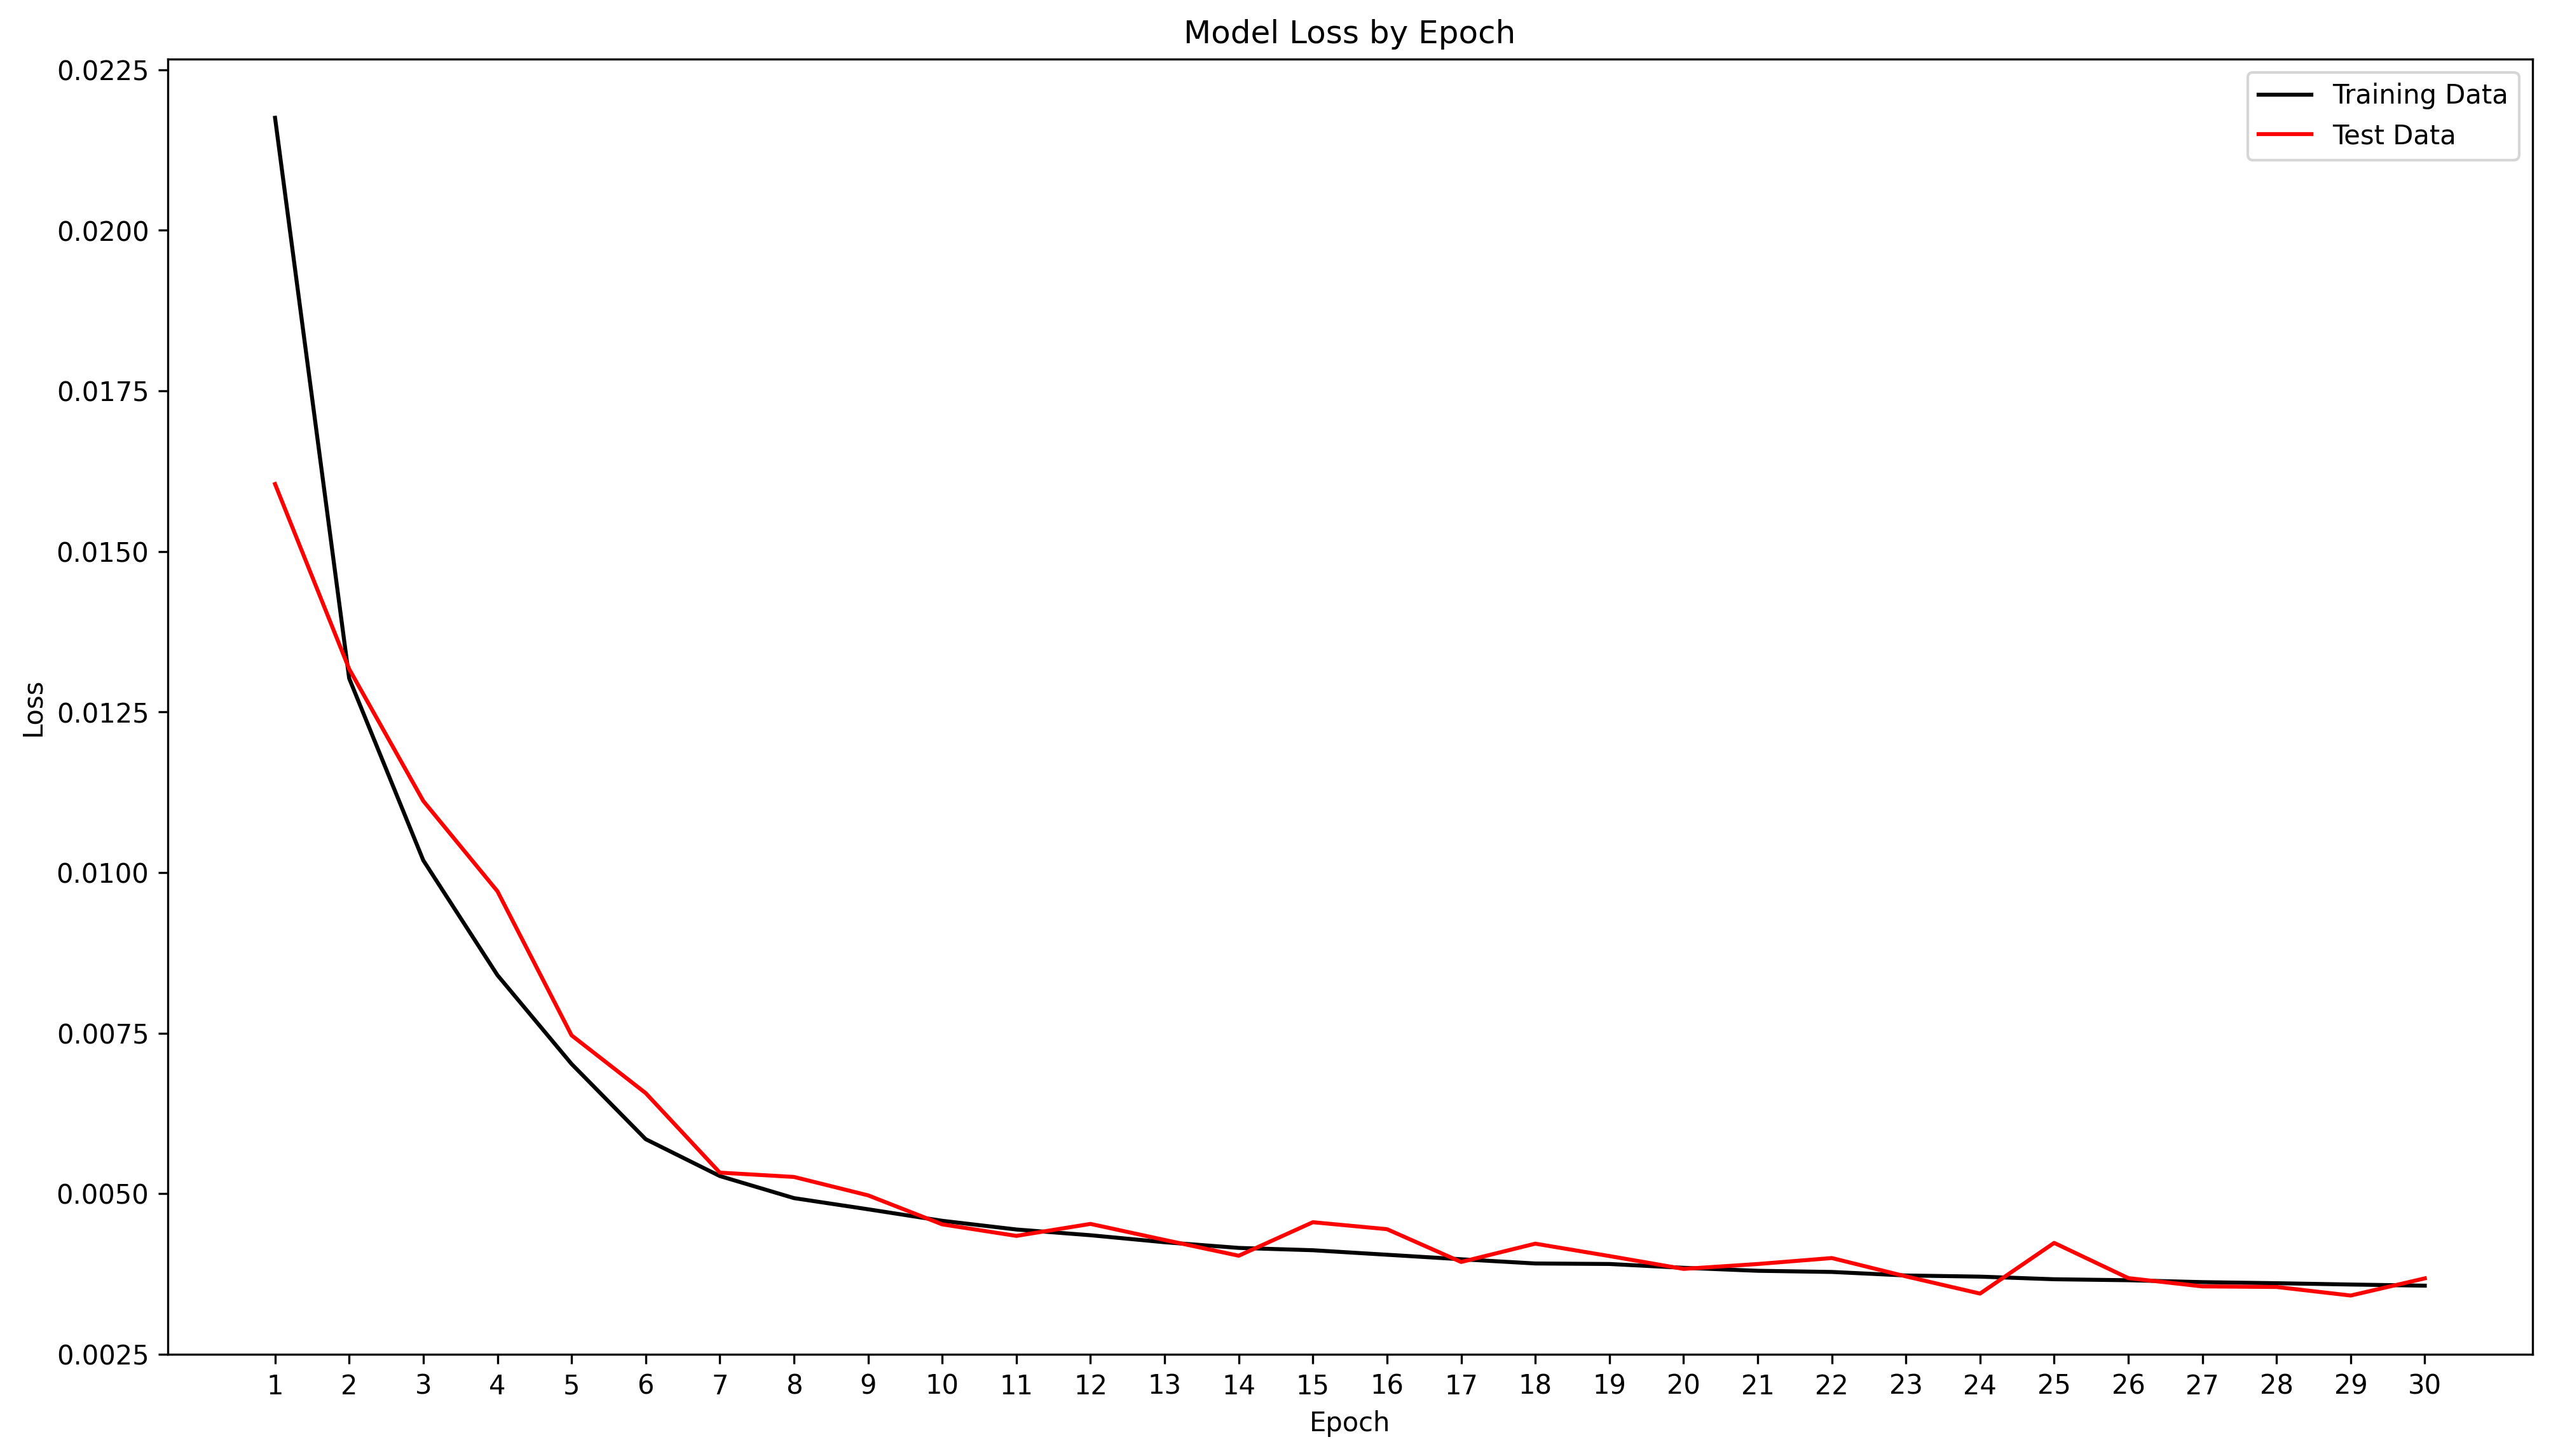

In [ ]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(H.history['loss'], label='Training Data', color='black')
ax.plot(H.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(H.history['loss'])), labels=np.arange(1, len(H.history['loss'])+1))
plt.legend()

plt.show()

## Test the model
To see how well the model performs we can now use `autoencoder.predict` over the test dataset

In [ ]:
predictions = autoencoder.predict(fashion_test_noisy)

By reshaping the images and plotting we can see how well it performs on actually denoise given images.

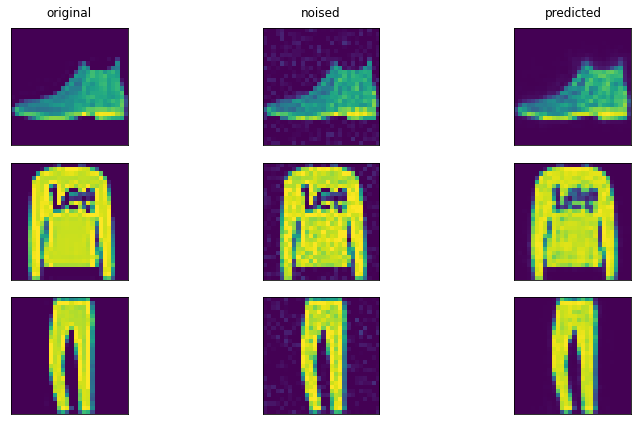

In [ ]:
predictions = predictions.reshape(10000, 28, 28)
fashion_test = fashion_test.reshape(10000, 28, 28)
fashion_test_noisy = fashion_test_noisy.reshape(10000, 28, 28)

fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
axs[0,0].set(title="original")
axs[0,1].set(title="noised")
axs[0,2].set(title="denoised")

for i in range(0,3):
  axs[i,0].matshow(fashion_test[i])
  axs[i,1].matshow(fashion_test_noisy[i])
  axs[i,2].matshow(predictions[i])

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

# The ConvAutoencoder
The second model we can look at is a convolutional denoiser autoencoder. The difference with the linear counterpart is that this is basically a convolutional neural network, so the activation is non linear, and is better suited to treat grid-like data (e.g. images and shapes).

Again, we can define wht width, height and depth (channels) of our image and the filters to apply in the convolutional neurons along with the encoded space dimensionality (by default 16, but in later training we'll more probably use a bigger size, since the starting images traslate into tensors of dimensionality (32x32x3)).

![Convolutional matrix visualization](https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif)

In this autoencoder we can also set the strides, in other words the _amount of movement_ in the visualization. The bigger the strides the smaller the resulting matrix, so setting the padding as "same" allows us to get as output a matrix of the same dimensions as the starting one. `Filters` and `latentDim` work in the same fashion as the previous network. 

In [ ]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16, strides=2):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=strides, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=strides,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

##  The dataset, CIFAR10
The choosen dataset for this part of the project is the CIFAR10 dataset. It is a collection of 60000 32x32 colour images grouped in 10 classes, with 6000 images per class (source: [CIFAR10 site](https://www.cs.toronto.edu/~kriz/cifar.html)). This dataset is very suited for the project because the images are not particularly big (32x32 is easily rapresentable with a vector) and has a lot of samples to choose from. It is also very similar to the MNIST dataset, and so we can treat it the same way (e.g. adding noise with the same function).

So we can download it

In [ ]:
print("[INFO] loading CIFAR10 dataset...")
((cifar_train, labels_cifar_train), (cifar_test, labels_cifar_test)) = cifar10.load_data()

cifar_train = cifar_train.astype("float32") / 255.0
cifar_test = cifar_test.astype("float32") / 255.0

cifar_train_noisy = add_noise_and_clip_data(cifar_train)
cifar_test_noisy = add_noise_and_clip_data(cifar_test)

[INFO] loading CIFAR10 dataset...
170508288/170498071 [==============================] - 2s 0us/step


And then visualize some samples of it

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


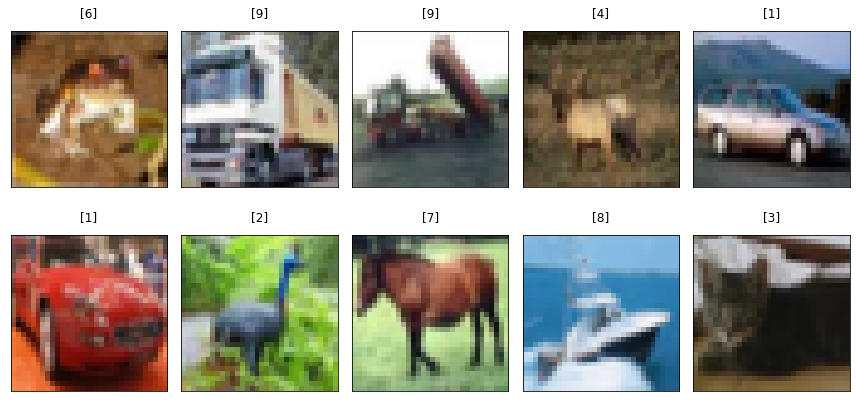

In [ ]:
# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6))
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(cifar_train[n])
        axs[i,j].set(title=labels_cifar_train[n])
        n=n+1

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

Since it is very similar to the MNIST dataset we can also noise it with the same function we deifined earlier and visualize the noised version of it.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


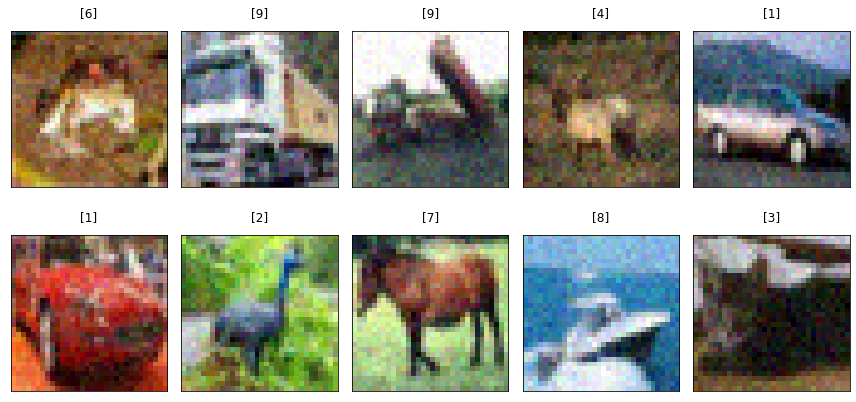

In [ ]:
# Display images of the first 10 digits in the training set and their true lables
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6))
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(cifar_train_noisy[n])
        axs[i,j].set(title=labels_cifar_train[n])
        n=n+1

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

# Hyperparameter optimization, Weights and Biases
Another very useful library we'll use is [weights and biases](https://wandb.ai/home). The library is actually a set of tools for machine learning, but what we are most interested in is the `sweep` tool. The `sweep` allow to run a K-fold cross validation with a specified number of classifiers and later get beautiful data on how they performed. 

![wandb visualization](https://github.com/badadumTss/convDAE/raw/main/imgs/wandb_results_run38.png)

This is for example the output of the last run I made that shows how the internal units, the latent encoded dimensionality and the learning ate affected each other in the resulting loss function value in the training process (since the training is pretty long and memory hungry and colab has a limit on both time and space I could not run more than 5 instances without at least one crashing, linke the one that has `null` as resulting loss function).

## Install wandb
Install wandb can be done easily trough pip, importing it results in a module that allows us to communicate with weights and biases in the cloud. with `.login()` we access an instance of wandb (i have an API key for this project: `popopop`, may be useful if asked to use it)

In [ ]:
!pip install wandb -qqq
import wandb

wandb.login()

wandb: Currently logged in as: badadumtss. Use `wandb login --relogin` to force relogin


True

## Configure wandb
To configure the sweep we start with a dictionary that says to wandb how to orchestrate its agent. The _method_ key says how to search in the parameters space, a grid search simply iterates over all possible values and evaluates them, the metric says how to interpret data, in this example we say that we want to minimize the loss function.

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    }
}

params = {
    'epochs': {
        'value': 5
    },
    'batch_size': {
        'value': 128
    },
    'filters': {
        'values': [(32, 64, 128), (32, 64, 128, 256)]
    },
    'latent_dim': {
        'value': 32
    },
    'learning_rate': {
        'values': [1e-3, 0.01]
    }
}

sweep_config['parameters'] = params


## Initialize the sweep
By calling `wandb.sweep` we initialize a sweep in the cloud and associate our run to a project. We also indicate our configuration to orchestrate the agent

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="convDAE")

Create sweep with ID: 1t6u9hdm
Sweep URL: https://wandb.ai/badadumtss/convDAE/sweeps/1t6u9hdm


## Define the training
The last step before run is to define a function that builds a mosel and trains it. The following function does so, by collecting the configuration from wandb and training the model against our dataset

In [ ]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config
    optimizer = Adam(learning_rate = config.learning_rate)
    # construct our convolutional autoencoder
    print("[INFO] building autoencoder...")
    (encoder, decoder, autoencoder) = ConvAutoencoder.build(32, 32, 3, 
                                                            filters=config.filters, 
                                                            latentDim=config.latent_dim)
    
    autoencoder.compile(loss="mse", optimizer=optimizer, metrics=['accuracy'])
    # train the convolutional autoencoder
    H = autoencoder.fit(
	    cifar_train_noisy, cifar_train,
	    validation_data=(cifar_test_noisy, cifar_test),
	    epochs=config.epochs,
	    batch_size=config.batch_size
    )
    
    wandb.log({ 'epochs': config.epochs,
                'filters': max(config.filters),
                'loss': np.mean(H.history['loss']),
                'accuracy': np.mean(H.history['accuracy']),
                'val_loss': np.mean(H.history['val_loss'])})

## Run the sweeper
Last step is to run. The sweeper will later display all the logged informations (in our case `epochs`, `filters`, `loss`, `accuracy` and `val_loss`) on the web.

In [ ]:
wandb.agent(sweep_id, train, count=5)

# Results

## Convolutional network and linear network comparison
The convolutional network, because of its structure, is better suited for this task, and the only way I could get comparable results with the linear activated network was by encoding the image in the same space as the input one, in oder words not encoding it (the tunes for the run are still those, by reducing the latent dimension one can see how the loss function overall increases).

## Wandb results
WandB is a very useful tool to tune very effectively the hyperparameters. The last results can be seen in the following graph

![wandb visualization](https://github.com/badadumTss/convDAE/raw/main/imgs/wandb_results_run38.png)

We can see how the learning rate is very important to lower the loss function value over a run, and how the intermediate layers actually have a negative impact on it. The lowest loss-valued run in fact has
```
filters = (32, 64, 128)
latent_dim = 32
learning_rate = 1e-3
```
### Further experiments
A possible future incremental step for the project, which goes beyond the available time and resources would be to modify the linear activation model in order to work with the RGB channels, train it, tune it and see how it performs compared to the con